# Classification with Imbalanced Data

## setup

In [1]:
import pandas as pd
import numpy as np # linear algebra
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, SCORERS, precision_recall_curve
from sklearn.metrics import average_precision_score, auc, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, LeaveOneOut

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

import graphviz

from sklearn.utils import resample

In [3]:
def score_prediction(y_test, y_pred):
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred):.3f}')
    print(f'Recall:    {recall_score(y_test, y_pred):.3f}')
    print(f'F1:        {f1_score(y_test, y_pred):.3f}')

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Orange Telecom's Churn

The Orange Telecom's Churn Dataset, which consists of cleaned customer activity data (features), along with a churn label specifying whether a customer canceled the subscription, will be used to develop predictive models. Two datasets are made available here: The churn-80 and churn-20 datasets can be downloaded.

The two sets are from the same batch, but have been split by an 80/20 ratio. As more data is often desirable for developing ML models, let's use the larger set (that is, churn-80) for training and cross-validation purposes, and the smaller set (that is, churn-20) for final testing and model performance evaluation.

https://www.kaggle.com/mnassrib/telecom-churn-datasets

In [5]:
df = pd.read_csv("https://github.com/giedriusblazys/SDA_DS_class/raw/main/practice/input/churn-bigml-80.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [7]:
def corr_plot(df):
    corr = df.corr()
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    )
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    )

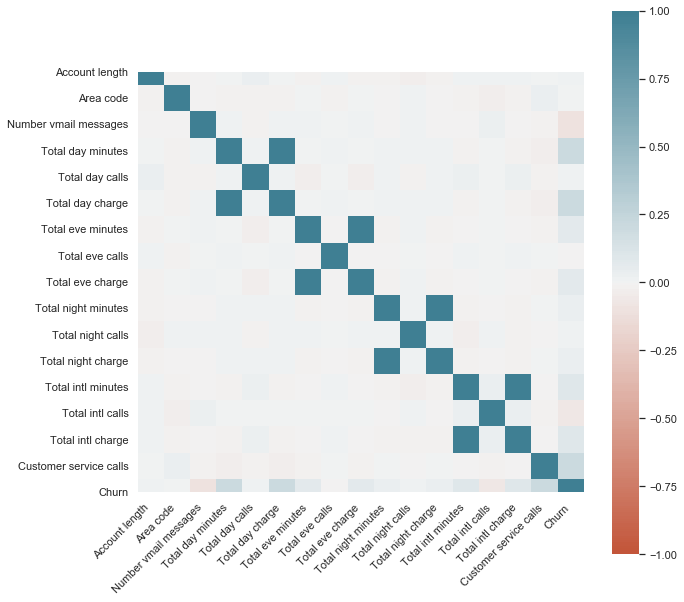

In [8]:
corr_plot(df)

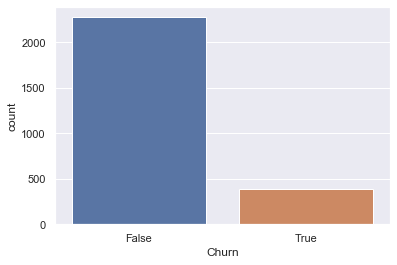

In [9]:
sns.countplot(x=df["Churn"]);

In [17]:
#spliting the data for target and features
X = df.drop(columns='Churn', axis=1)
y = df['Churn'].astype('int')

#creating the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state = 42, stratify=y)
print(f'X_train: {X_train.shape}, X_test{X_test.shape}')

## One-hot encoder

s = (X_train.dtypes == 'object')
obj_cols = list(s[s].index)

OH_encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')

X_train_array = OH_encoder.fit_transform(X_train[obj_cols]).toarray()
OH_cols_train = pd.DataFrame(X_train_array, columns = OH_encoder.get_feature_names_out())

X_test_array = OH_encoder.transform(X_test[obj_cols]).toarray()
OH_cols_test = pd.DataFrame(X_test_array, columns = OH_encoder.get_feature_names_out())
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(obj_cols, axis=1)
num_X_test = X_test.drop(obj_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
# OH_X_train.columns

X_train: (133, 19), X_test(2533, 19)


/Users/giedrius/anaconda3/envs/scipy/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
